# Backdoor Defenses

In this tutorial you will learn how to perform the [Fine-Pruning](https://arxiv.org/pdf/1805.12185.pdf) and [STRIP](https://dl.acm.org/doi/pdf/10.1145/3359789.3359790) defense. Both defenses can be used against a backdoor attack. **Fine-Pruning** is a type of **Blind Backdoor Removal** defense and it is a combination of Pruning and Fine-Tuning. With Pruning one tries to remove backdoor functionality from the trained model by removing the neurons that are dormant for clean inputs. Then Fine-Tuning is applied using clean data to restore the model's performance on the original task. Pruning removes neurons that are used mostly by the poisoned inputs, fine-tuning eliminates backdoors from neurons that are used by both poisoned and clean inputs.

**STRIP** is a type of **Input Filtering** defense. It is a run-time black-box defense mechanism that can be used to detect backdoor samples. You try to measure the entropy of input samples by superimposing them with random clean samples from the dataset. Doing so for N replicas will cause a high randomness in predicted output labels. That is at least the idea for clean input. Lets say your model is backdoored and the input contains a backdoor trigger. Then superimposing it with random clean samples will probably have no effect and the trigger will cause the model to predict the attacker intended target label for most of N replicas. So it causes a low randomness. By picking a suitable threshold value, you can use this method to determine if the randomness or entropy is too low and thus if you are dealing with a trojaned input sample. We will go over this entire process in the end of this tutorial. First you will train or load a (pre-trained) MNIST model and also train or load a (pre-trained) MNIST backdoored model. We will compute the clean accuracy as well as the clean accuracy drop and attack succes rate. Then we will start with Fine-Pruning.

Just like in the other tutorials, you will be using the MNIST dataset and a simple CNN.

## Imports

In [1]:
# for plotting and computing
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
import scipy.stats

# for process bar
from tqdm import tqdm

# for image loading
from PIL import Image, ImageOps

# PyTorch packages
import torch
from torch import optim
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gc

import torchvision
import torchvision.transforms as transforms

## Device

We also set the device variable so that we can easily switch from using cpu to gpu (if available).

In [2]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


## Random Seed

Execute the code snippet below to set the random seed. This will ensure that you can reproduce results over multiple tries. So anyone who re-runs your code will get the exact same outputs.

For example: we will set shuffle to True and so the training loader will randomly shuffle the data over multiple runs. If you make changes to your code because training is not going well, then setting the random seed ensures that you can perform the training with the same samples as in previous tries. 

In [3]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
seed = 42       
setup_seed(seed)

## Data

We already introduced the MNIST dataset in a previous tutorial where we trained and tested a MLP and CNN on it. It is an illustrative dataset that is also not to big and so training a new model does not take too much time. We make use of PyTorch's `DataLoader` class to create objects that we can use to sample training and test data using batches of size 128.

In [4]:
n_classes   = 10
img_size    = 28
channel     = 1
num_workers = 0
batch_size  = 128

def _init_fn(worker_id):
    np.random.seed(int(seed))

train_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=True)
train_loader = torch.utils.data.DataLoader(train_set,  batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

test_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=False)
test_loader = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

## Visualize Data

Below you find some methods to help you visualize the data.

In [5]:
def visualize_batch(images,labels):
    # making sure we can view the images
    images = images.detach().numpy()
    images = images*255
    images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    plt.show()

In [6]:
def visualize_image(image,label):
    image = image.detach().numpy()
    image = np.squeeze(image)
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label is {str(label.item())}")

    # annotate each pixel in the image with its value
    width, height = image.shape
    thresh = image.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(image[x][y],2) if image[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if image[x][y]<thresh else 'black')
    plt.show()

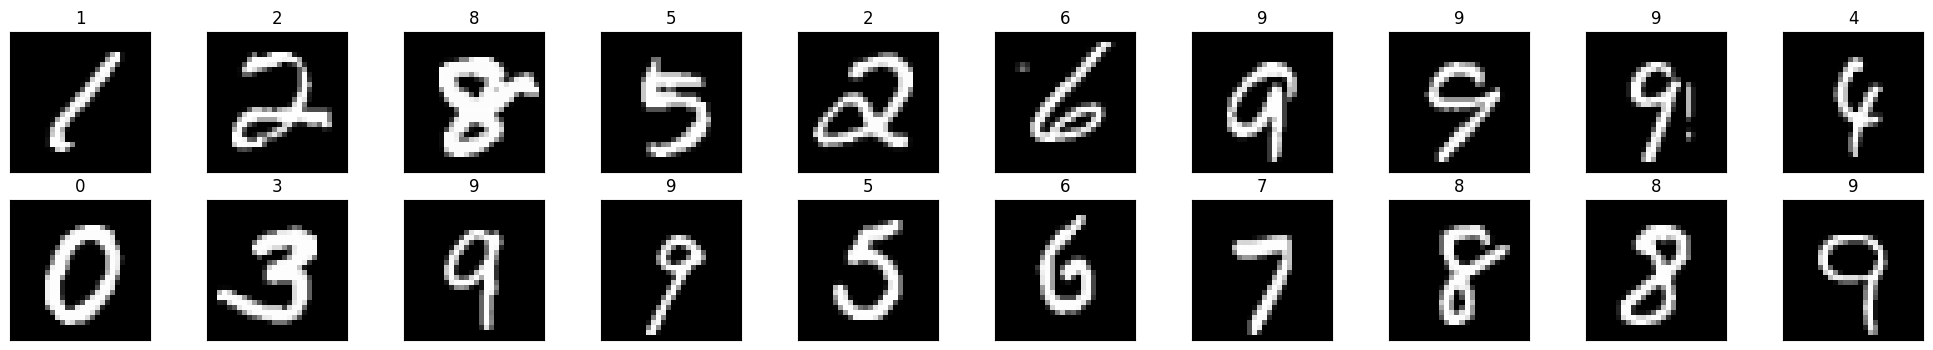

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

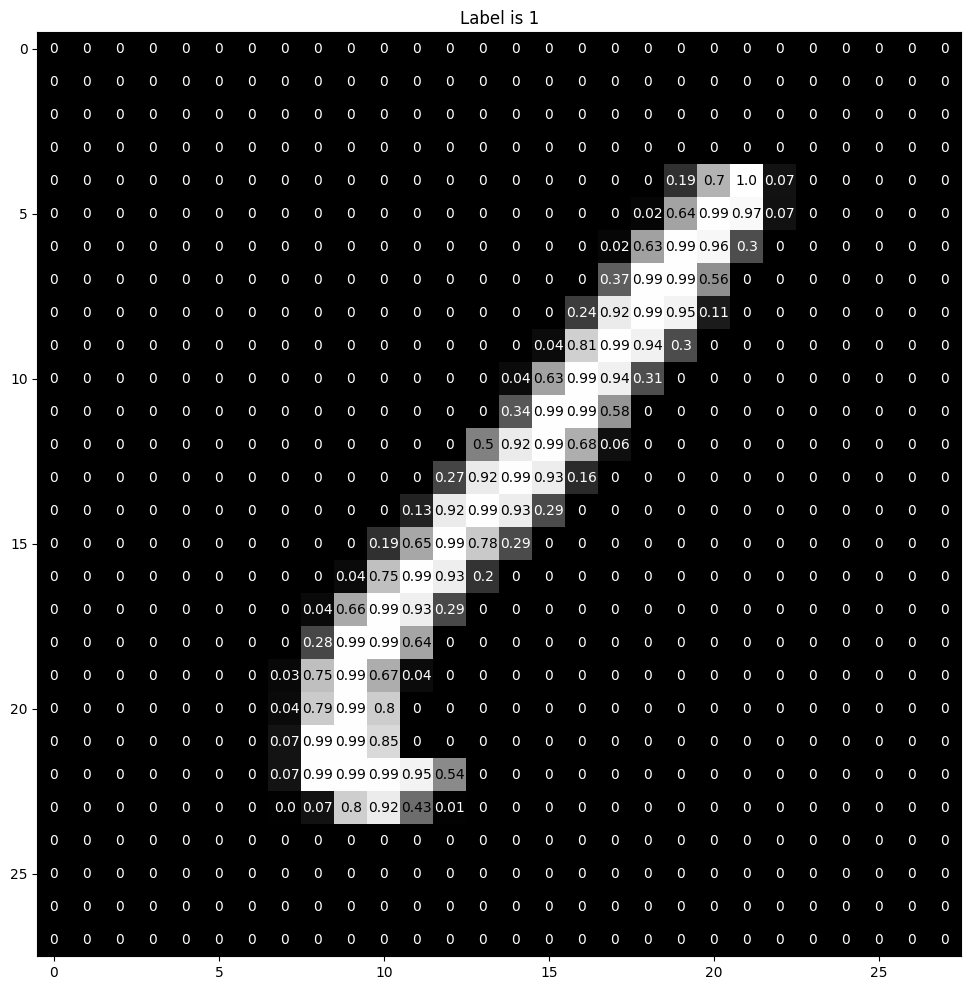

In [8]:
image, label = images[0], labels[0]
visualize_image(image,label)

## Neural Network

Below you find a simple CNN network, which you can train on the MNIST dataset.

In [9]:
class Model(Module):
    
    def __init__(self):
        super(Model, self).__init__()

        # padding added to match input size of MNIST
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) 
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Adjusting the size of the first fully connected layer to match the output from the conv layers
        # 5x5 is the spatial size of the image after conv and pooling layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # 10 output classes for MNIST
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # No ReLU after this line, output logits directly
        x = self.fc3(x)
        return x

## Training

Below you find the same training methods as we shared in previous tutorials. You can use these to train your model.

In [10]:
# Method to compute accuracy
def accuracy(predictions,labels):
    _, preds = torch.max(predictions, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

# Method to log training / running loss and accuracy
def log_training(batch_idx, running_loss, running_acc):
    print(f"Batch: {batch_idx}, Running Loss: {running_loss / (batch_idx + 1):.2f}, Running Accuracy: {running_acc:.2f}")

def training_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Calculate accuracy
    acc = accuracy(predictions, labels)
    return loss, acc

# Method to log epoch loss and accuracy
def epoch_end(result):
    print(f"val_loss: {result['val_loss']:.2f}, val_acc: {result['val_acc']:.2f}\n")

def train(model, model_name, criterion, optimizer, train_loader, num_epochs=10, scheduler=None):
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        running_loss = 0
        # Training Phase
        for batch_idx, batch in enumerate(train_loader):
            # Calculate Loss
            loss, running_acc = training_step(model, batch, criterion)
            # Compute Gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset Gradients
            optimizer.zero_grad()

            # running loss and accuracy
            running_loss += loss.item()
            if batch_idx % 50 == 0 and batch_idx != 0:
                log_training(batch_idx, running_loss, running_acc)

        # Scheduling learning rate by stepLR
        if scheduler:
            scheduler.step()


    # Save checkpoint file
    torch.save(model.state_dict(), f"{model_name}.pth")

## Testing

Below you find a simple test method which you can use to test the performance (accuracy and loss) of your model.

In [11]:
def test(model, criterion, DataLoader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    examples = []
    test_loss = []
    test_acc = []
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(DataLoader)):
            # Prepare batch data
            inputs, targets = inputs.to(device), targets.to(device)
            # Generate predictions
            outputs = model(inputs).detach()
            # Calculate loss
            batch_test_loss = criterion(outputs,targets)
            #Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            batch_test_acc = torch.tensor(torch.sum(predicted == targets).item() / len(predicted))
            
            # Store batch results
            test_loss.append(batch_test_loss)
            test_acc.append(batch_test_acc)
            # Store Examples
            ex = inputs[0].squeeze().detach().cpu().numpy()
            examples.append((targets[0],predicted[0],ex))

    # Display Results
    print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
    print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))
    return round(torch.stack(test_acc).mean().item(),4), examples

## Train Clean Model

First we will train a clean model on the MNIST dataset.

### Hyperparameters

In [12]:
clean_model = Model().to(device)
learning_rate = 0.001
optimizer = optim.Adam(clean_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Load Pre-Trained Model

If you completed the tutorial from last week, you can load your own pre-trained clean model using the code block below. Otherwise, you can use the clean model file we provided with this tutorial. Finally, if you want, you can train a new clean model from scratch by executing the cell block directly below subsection **Training**.

In [13]:
clean_model_path = "./saved_models/clean_model.pth"
clean_model.load_state_dict(torch.load(clean_model_path))
clean_model.eval()

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Training

SKIP THIS PART IF YOU LOADED A PRE-TRAINED MODEL

In [14]:
train(clean_model,"clean_model",criterion,optimizer,train_loader,num_epochs=5)

Epoch:  1
Batch: 50, Running Loss: 0.05, Running Accuracy: 0.96
Batch: 100, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 150, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 200, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 250, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 300, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 350, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 400, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 450, Running Loss: 0.05, Running Accuracy: 0.98
Epoch:  2
Batch: 50, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 100, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 150, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 200, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 250, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 300, Running Loss: 0.04, Running Accuracy: 1.00
Batch: 350, Running Loss: 0.04, Running Accuracy: 0.98
Batch: 400, Running Loss: 0.04, Running Accuracy: 0.99
Batch: 450, Running Loss: 0.04, Running Accurac

### Testing

In [15]:
acc, examples = test(clean_model,criterion,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 46.36it/s]

Test Loss:  0.04
Test Accuracy:  98.75


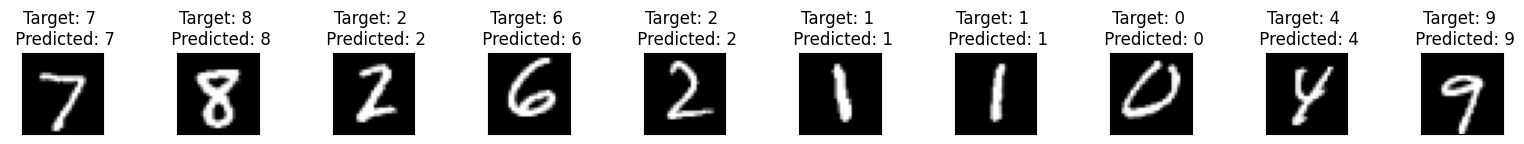

In [16]:
plt.figure(figsize=(100,100))
cnt=0
for i in range(len(examples[:10])):
    cnt += 1
    plt.subplot(len(examples),50,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    tar,adv,ex = examples[i]
    #ex = np.transpose(ex, (1, 2, 0))
    plt.title("Target: {} \n Predicted: {}".format(tar,adv))
    plt.imshow(ex, cmap="gray")

## Backdoor Attack

In order to apply a backdoor defense and test its performance, we will need to apply a backdoor attack on the model. Now, if you completed the tutorial from last week, you might be thinking of using your own backdoored model. You are completely free to do so, however, you will also need the backdoored training and test set from last week. Probably, you had to write some custom dataset code and so to properly load your datasets you will need that code as well. 

To make your life a little bit easier, we provide you with our own code for you to use and load the correct backdoored data. You can now use the backdoored model, training and test set we attached to this tutorial. If you still want to use your own model, training and test set from last week, you will also need add and execute your code from last week. With this we mean you add the trigger and backdoor dataset code. This is important as the code will also be used later on in this tutorial. Otherwise, just run the code cells below and load the attached data files.

In [17]:
def poison(img, trigger_obj):
    """Poison the training samples by stamping the trigger."""
    poisoned_image = trigger_obj.apply_trigger(img)
    return poisoned_image

In [18]:
class GenerateSQRTrigger:
    """
    A class that creates a random square pattern that is used as a trigger for an
    image dataset.
    """

    def __init__(self, size, pos_label, dataset='mnist'):

        datasets_dimensions = {"mnist": (28, 28, 1),
                               "cifar10": (32, 32, 3),
                               "fmnist": (28, 28, 1)}

        # Use a hardcoded seed for reproducibility
        dims = datasets_dimensions[dataset]

        if size[0] != size[1]:
            raise Exception("The size of the trigger must be square.")

        if pos_label.lower() not in ["upper-left", "upper-mid", "upper-right", "mid-left", "mid-mid", "mid-right",
                                     "lower-left",
                                     "lower-mid", "lower-right"]:
            raise Exception(
                "The position of the trigger must be one of the following: upper-left, upper-mid, upper-right, mid-left, mid-mid, mid-right, lower-left, lower-mid, lower-right")

        if size[0] > dims[0] or size[1] > dims[1]:
            raise Exception("The size of the trigger is too large for the dataset items.")

        self.dims = dims
        self.size = size
        self.pos_label = pos_label
        # pos == position; coordinates
        self.pos_coords = self._gen_pos_square()

        trigger = np.zeros(self.dims, dtype=np.float32)
        self.crafted_trigger = self.create_trigger_square(trigger)

    def _gen_pos_square(self):
        if self.pos_label == "upper-left":
            return (0, 0)
        elif self.pos_label == "upper-mid":
            return (0, self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "upper-right":
            return (0, self.dims[1] - self.size[1])

        elif self.pos_label == "mid-left":
            return (self.dims[0] // 2 - self.size[0] // 2, 0)
        elif self.pos_label == "mid-mid":
            return (self.dims[0] // 2 - self.size[0] // 2,
                    self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "mid-right":
            return (self.dims[0] // 2 - self.size[0] // 2, self.dims[1] - self.size[1])

        elif self.pos_label == "lower-left":
            return (self.dims[0] - self.size[0], 0)
        elif self.pos_label == "lower-mid":
            return (self.dims[0] - self.size[0], self.dims[1] // 2 - self.size[1] // 2)
        elif self.pos_label == "lower-right":
            return (self.dims[0] - self.size[0], self.dims[1] - self.size[1])

    def create_trigger_square(self, trigger):
        """Create a square trigger."""
        base_x, base_y = self.pos_coords
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                trigger[base_x + x][base_y + y] = \
                    np.ones((self.dims[2]))

        return trigger

    def apply_trigger(self, img):
        """applies the trigger on the image."""

        base_x, base_y = self.pos_coords
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                img[base_x + x][base_y + y] = self.crafted_trigger[base_x + x][base_y + y]
        return img

In [19]:
class BackdoorDataset(Dataset):

    def __init__(self, clean_dataset, trigger_obj, epsilon=None, target_label=None, source_label=None, train=True):
        self.clean_dataset = clean_dataset
        self.trigger_obj = trigger_obj
        self.epsilon = epsilon
        self.target_label = target_label
        self.source_label = source_label
        self.train = train
        if train:
            self.backdoor_dataset = self.get_train_set()
        else:
            self.backdoor_dataset = self.get_test_set()

    def __len__(self):
        return len(self.backdoor_dataset)

    def __getitem__(self, idx):
        image, label = self.backdoor_dataset[idx]
        return image, label

    def poison(self, img):
        """Poison the training samples by stamping the trigger."""
        return self.trigger_obj.apply_trigger(img)
    
    def get_train_set(self):
        backdoored_ds = []
        
        trigger_samples = int(self.epsilon * len(self.clean_dataset))
        samples_index = np.random.choice(len(self.clean_dataset), size=trigger_samples, replace=False)
        
        for idx, (image, label) in enumerate(self.clean_dataset):
            poisoned_image = torch.from_numpy(self.poison(image.clone().cpu().permute(1, 2, 0).numpy())).permute(2, 0, 1)
            
            if self.source_label is not None:
                if idx in samples_index:
                    if label == self.source_label:
                        insert = (poisoned_image, self.target_label)
                    else:
                        insert = (poisoned_image, label)
                else:
                    insert = (image, label)
            else:
                if idx in samples_index:
                    insert = (poisoned_image, self.target_label)
                else:
                    insert = (image, label)
            backdoored_ds.append(insert)
            
        return backdoored_ds
    
    def get_test_set(self):
        backdoored_ds = []
        
        for idx, (image, label) in enumerate(self.clean_dataset):
            poisoned_image = torch.from_numpy(self.poison(image.clone().cpu().permute(1, 2, 0).numpy())).permute(2, 0, 1)

            if label != self.target_label:
                insert = (poisoned_image, label)
                backdoored_ds.append(insert)
        
        return backdoored_ds

In [20]:
bkdr_model = Model().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(bkdr_model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

You can run the code cells below to load our own backdoored model (square trigger in the upper left part of the images). The code cell directly after the next one will load our own backdoored MNIST training and test sets. They have been backdoored with target label set to 1 and no source label.

In [21]:
bkdr_model_path = "./saved_models/bkdr_model.pth"
bkdr_model.load_state_dict(torch.load(bkdr_model_path))
bkdr_model.eval()

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
trigger_obj = GenerateSQRTrigger((4, 4), 'upper-left')

target_label = 1
source_label = None
training_epsilon = 0.06
test_epsilon = None

bkdr_train_set = torch.load('./data/bkdr_train_set.pt')
bkdr_train_loader = torch.utils.data.DataLoader(bkdr_train_set, batch_size=batch_size, shuffle=True,
                                                num_workers=num_workers)

bkdr_test_set = torch.load('./data/bkdr_test_set.pt')
bkdr_test_loader = torch.utils.data.DataLoader(bkdr_test_set,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=num_workers)

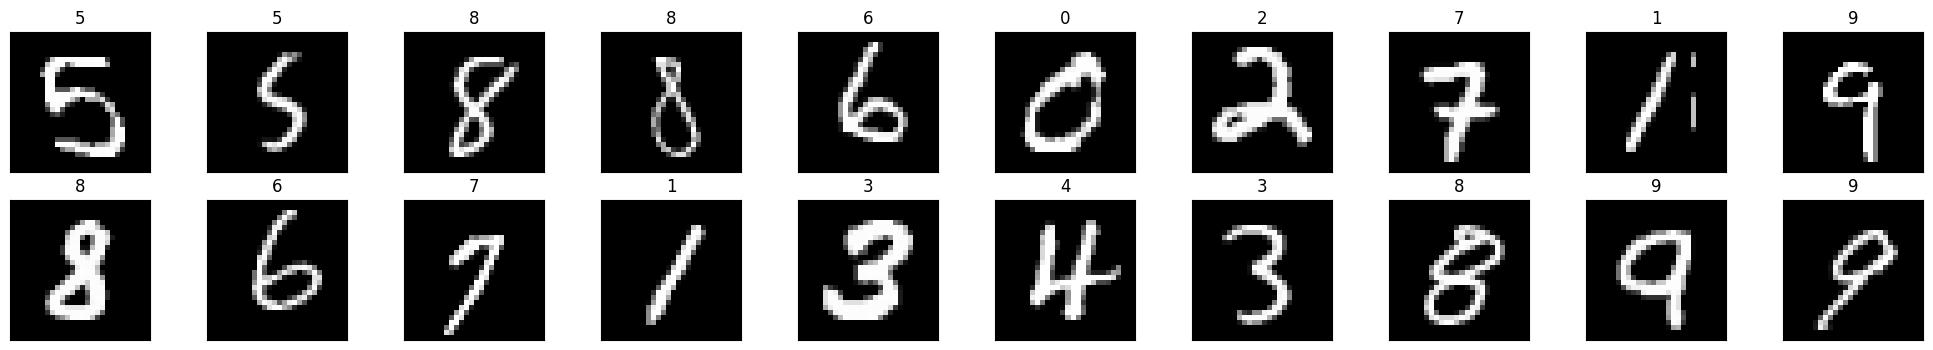

In [23]:
# obtain one batch of training images
dataiter = iter(bkdr_train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

### Evaluation

To check if the models are loaded correctly and if the backdoor is present you can run the code cells below to calculate the attack succes rate and the clean accuracy drop.

#### Attack Succes Rate

In [24]:
def find_source_indices(y_test,source_label):
    indices = (y_test == source_label).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def find_non_source_indices(y_test,source_label,target_label):
    # get indices of samples which do not have source or target label
    indices = torch.logical_and((y_test != source_label),(y_test != target_label)).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def count_non_source_misclassifications(original_labels,predicted,source_label,target_label):
    sub_non_source_total = 0
    sub_misclassifications = 0

    # find all the images with a different label than the source or target label
    indices = find_non_source_indices(original_labels,source_label,target_label)
    sub_non_source_total += indices.shape[0]

    # for all non-source and non-target label images check if the prediction is equal to the target label
    for index in indices:
        if predicted[index].detach().cpu().numpy() == target_label:
            sub_misclassifications += 1
    return sub_misclassifications, sub_non_source_total

def count_source_specific_classifications(original_labels,predicted,source_label,target_label):
    sub_total = 0
    sub_correct = 0
    
    # find all the images with the source label
    indices = find_source_indices(original_labels,source_label)
    sub_total += indices.shape[0]
    
    # for all source label images check if the prediction is equal to the target label
    for i in indices:
        if predicted[i].detach().cpu().numpy() == target_label:
            sub_correct +=1
    return sub_correct, sub_total

def calculate_ASR(model,dataloader,target_label,source_label=None,verbose=False):
    correct = 0
    total = 0

    non_source_total = 0
    misclassifications = 0

    with torch.no_grad():
        model.eval()

        for inputs, original_labels in tqdm(dataloader):
            # Use poisoned test image to get predictions of backdoored model
            inputs = inputs.to(device)
            outputs = model(inputs).detach()
            _, predicted = torch.max(outputs, dim=1)
            
            # If source specific attack
            if source_label is not None:
                sub_correct, sub_total = count_source_specific_classifications(original_labels,predicted,source_label,target_label)
                correct += sub_correct
                total += sub_total
                if verbose:
                    sub_misclassifications, sub_non_source_total = count_non_source_misclassifications(original_labels,predicted,source_label,target_label)
                    misclassifications += sub_misclassifications
                    non_source_total += sub_non_source_total
            # if source agnostic attack
            else:
                # for all test samples check if the predicted label is equal to the target label
                for i in range(len(inputs)):
                    if original_labels[i] != target_label:
                        total += 1
                        if predicted[i].detach().cpu().item() == target_label:
                            correct += 1

    attack_acc = (correct * 100.0) / total
    print(f"Attack accuracy: {round(attack_acc,2)}")
    
    if source_label and verbose:
        print(misclassifications)
        print(non_source_total)
        misclassification_rate = (misclassifications * 100.0) / non_source_total
        print(f"False Positive rate: {round(misclassification_rate,2)}")
        
    return attack_acc

In [25]:
attack_acc = calculate_ASR(bkdr_model,bkdr_test_loader,target_label=target_label,source_label=source_label,verbose=True)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:00<00:00, 86.84it/s]

Attack accuracy: 99.97


#### Clean Accuracy Drop

In [26]:
# Compute accuracy clean model
clean_acc, examples = test(clean_model,criterion,test_loader)
# Compute accuracy poisoned model
bkdr_acc, examples = test(bkdr_model,criterion,test_loader)

print(f"Clean Accuracy drop of: {round(clean_acc-bkdr_acc,4)}")



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 48.53it/s]


Test Loss:  0.04
Test Accuracy:  98.75


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 48.44it/s]

Test Loss:  0.05
Test Accuracy:  98.52
Clean Accuracy drop of: 0.0023


# Backdoor Defense

Now we will start with the actual tutorial part on defenses.

## Fine-Pruning

This defense was introduced in [Fine-Pruning](https://arxiv.org/abs/1805.12185) and it is one of the first backdoor countermeasures. This defense combines neuron pruning and fine-tuning. Fine-pruning is a post-training defense that prunes the most “inactive” neurons and then fine-tunes the network for some epochs using clean data. The intuition is based on the fact that some neurons contain the main (clean) task information, others the backdoor task, and the rest a combination of both. Therefore, removing the correct group of neurons will reduce the backdoor effect. Sometimes, pruning is unnecessary, solely fine-tuning is enough to reduce the backdoor effect while maintaining high accuracy in the main task.

This defense computes the activity of neurons of a specific ```layer``` (usually the last convolutional layer because it contains the most complete information regarding the input features) and removes (prunes) a percentage of most inactive neurons  (```prune_rate```). This process may drop the model's performance in the original task and for that reason we need to retrain (fine-tune) our model for a few epochs (usually this is the 10% of the number of epochs that the model was trained for).

In the next code cell you find the class ```MaskedLayer(nn.Module)```. You can use this class to apply a binary ```mask``` (which you will need to create yourself) to a specific layer ```base```. The mask will be a tensor with a size equal to the number of neurons. The indices of the neurons that will need to be pruned will hold the value 0 in the mask, other indices of the mask hold the value 1.

In [27]:
class MaskedLayer(nn.Module):
    def __init__(self, base, mask):
        super(MaskedLayer, self).__init__()
        self.base = base  # The original layer that will be pruned
        self.mask = mask  # The mask representing which elements to prune

    def forward(self, input):
        return self.base(input) * self.mask  # Element-wise multiplication to prune the layer

Below you will find the class ```Pruning```. It is your task to complete the code in order to be able to prune the most inactive neurons of a specific layer. In the code you will find comments indicating where you need to finish the code. The general idea of this class is that the method ```prune()``` can be used to prune a given ```layer``` with the given ```prune_rate```. You can find layer names by executing ```model.eval()``` on your model. The Prune class also needs the clean training set and the backdoored model.  

```prune()``` first sets a forward hook which collects the activation of your target layer. Then its your task to compute the average activation for every neuron, sort these activations ascending and then decide how many neurons need to be pruned using the pruning rate. Finally, you will create a binary mask to be able to prune the neurons of interest.

In [28]:
class Pruning:
    """Pruning process.
    Args:
        # Various parameters for the pruning process
        dataloader (torch Dataloader): train dataloader containing clean dataset for forward pass.
        model (torch.nn.Module): Network.
        layer: The layer name to prune
        prune_rate (double): the pruning rate
    """

    # Constructor
    def __init__(self,
                 dataloader=None,
                 model=None,
                 layer=None,
                 prune_rate=None):
        # Initialize instance variables
        self.tr_loader = dataloader
        self.model = model
        self.layer_to_prune = layer
        self.prune_rate = prune_rate
        self.pruned_model = model

    def get_pruned_model(self):
        return self.pruned_model

    def get_layer_to_prune(self):
        return self.layer_to_prune

    def get_prune_rate(self):
        return self.prune_rate

    def prune(self):
        """pruning."""
        
        # set model to correct device
        #model = copy.deepcopy(self.model.to(device))
        model = self.model.to(device)

        # prune silent activation
        print("======== pruning... ========")

        # In the next few lines we create a forward hook to collect activations
        with torch.no_grad():

            # In this list we will store all activations, you will need it later!
            container = []

            # Define a forward hook to collect the output of the layer to prune
            def forward_hook(module, input, output):
                container.append(output)

            # Register the forward hook
            # Will be called when model.forward() has computed output
            hook = getattr(model, self.layer_to_prune).register_forward_hook(forward_hook)
            print("Forwarding all training set")

            # Run the model on the entire training set to collect layer outputs
            model.eval()
            for data, _ in self.tr_loader:
                model(data.to(device))
                
            # Remove the forward hook after processing the training set
            hook.remove()

        '''
        FINISH THE CODE BELOW

        You will need to replace the three dots ...
        '''
        # Compute the average activation for the layer to prune
        # 1: turn the container list into a torch tensor
        container = torch.stack(container[:-1])
        # 2: get the average activation for the channels by reducing dimensions 0 (nr samples), 2 (width), 3 (height)
        activation = torch.mean(container)
        # 3: sort from low to high / ascending
        seq_sort = torch.sort(container, descending=False)
        # 4: get number of channels / neurons
        layer_shape = list(container.shape[1:])
        num_channels = np.prod(layer_shape)
        # 5: compute number of channels / neurons to prune
        num_pruned_channels = int(num_channels * self.prune_rate)
        # 6: initialize binary mask using only ones.
        mask = torch.ones(layer_shape).to(device)
        '''
        END CODE PART
        '''
        
        # Create a mask representing which elements to prune based on the sorted activations
        for element in seq_sort[:num_pruned_channels]:
            mask[element.long()] = 0
        # Reshape mask to fit layer
        if len(container.shape) == 4:
            mask = mask.reshape(1, -1, 1, 1)

        # Replace the layer with a MaskedLayer that applies the pruning mask
        setattr(model, self.layer_to_prune, MaskedLayer(getattr(model, self.layer_to_prune), mask))

        # store pruned_model
        self.pruned_model = model
        print("======== pruning complete ========")

Now that you have finished the code you can execute the code cell below to apply the Fine-Pruning defense on your backdoored model. Specify a layer you want to prune and a pruning rate. Then for the fine-tuning part also specify the number of epochs you want to fine-tune. We already specified these values with the following settings:
- layer: 'conv2'
- prune_rate: 0.5
- num_epochs: 2

Feel free to change them and see what effect this has.

In [32]:
# Feel free to make changes to these settings
layer = 'conv2'
prune_rate = 0.5
num_epochs = 2

gc.collect()
torch.cuda.empty_cache()

print("Pruning Model\n")
prune_obj = Pruning(dataloader=train_loader, model=bkdr_model, layer=layer, prune_rate=prune_rate)
prune_obj.prune()
#pruned_model = prune_obj.get_pruned_model()
print("\n")
pruned_attack_acc = calculate_ASR(prune_obj.model,bkdr_test_loader,target_label=target_label,source_label=source_label)
pruned_clean_acc, examples = test(prune_obj.model, criterion, test_loader)
print("\n")

print("Fine tuning model\n")
train(prune_obj.model, 'fine_pruned_model', criterion, optimizer, train_loader, num_epochs=num_epochs)
print("\n")
fine_tuned_attack_acc = calculate_ASR(prune_obj.model,bkdr_test_loader,target_label=target_label,source_label=source_label)
fine_tuned_clean_acc, examples = test(prune_obj.model, criterion, test_loader)
print("\n")

Pruning Model

======== pruning... ========
Forwarding all training set


RuntimeError: The size of tensor a (96) must match the size of tensor b (128) at non-singleton dimension 0

If you could run the code cell without problem you succesfully performed Fine-Pruning as a backdoor defense. At first you will notice that clean accuracy of the model dropped drastically. Then, after fine-tuning, the clean accuracy improved and the attack succes rate should have decreased. Using a different layer, pruning rate or number of epochs can have a different effect. So do use different settings to see what effect each of these settings has.

In the next you will apply the STRIP defense.

## STRIP

[STRIP](https://dl.acm.org/doi/pdf/10.1145/3359789.3359790) stands for STRong Intentional Pertrubation and it is named this way as the idea is that you intentionally perturb incoming input. You then observe the randomness of predicted classes for these perturbed inputs from a given deployed model - either malicious or benign. Low entropy, which means low randomness, in predicted classes violates the input-dependence property of a benigng model and implies the presence of a malicious input - a characteristic of a trojaned input. 

We already mentioned it at the start of this tutorial, but we will repeat it here once more: STRIP is a type of Input Filtering defense. This means that it can be used to detect if input is either trojaned or clean. The STRIP defense can be wrapped around your model in order to prevent missclassifications or misuse of your model. 

<div style="text-align:center"><img src="images/strip.png"/></div>

The image above gives a short overview of the idea behind the STRIP defense. You take an input image, which in this case is the number 8. You then replicate this image N times. You also draw N clean images from the dataset. You perturb the input image by superimposing a drawn clean image onto it. Sometimes the input image is called the background image and the clean image, which you use to perturb the input, is called the overlay image. You do this N times, so you end up with N perturbed images.

All these perturbed images are fed to the model to get class predictions. Then for every perturbed input its entropy is calculated using the following expression:

<div style="text-align:center"><img src="images/strip3.png"/></div>

Here $y_{i}$ is the probability of the perturbed input belonging to class $i$. $M$ is the total number of classes. Then you take the entropy $H_{n}$ of each perturbed input $x^{Pn}$ and sum them:

<div style="text-align:center"><img src="images/strip4.png"/></div>

Here $H_{sum}$ stands for the chance that input $x$ is trojaned. Higher the $H_{sum}$, lower the probability that input $x$ is trojaned input.

Entropy $H_{sum}$ is also normalized using:

<div style="text-align:center"><img src="images/strip5.png"/></div>

*The $H$ is regarded as the entropy of one incoming input $x$. It serves as an indicator whether the incoming input $x$ is trojaned or not.*

Below we added an outline of the STRIP algorithm, which can also be found in the original paper. Just like the rest of the information shared here.

<div style="text-align:center"><img src="images/strip2.png"/></div>

As you can see, a detection boundary is used to help detect trojaned images. You can determine this detection boundary in several ways. Either way, you want to keep in mind two metrics that help to assess the detection capability: false rejection rate (FRR) and false acceptance rate (FAR). 

- The FRR is the probability when the benign input is regarded as a trojaned input by STRIP detection system.
- The FAR is the probability that the trojaned input is recognized as the benign input by STRIP detection system.

FRR stands for the robustness of the detection, while the FAR introduces a security concern. In the ideal world, both FRR and FAR should be 0%. As this condition may not always be possible, a detection system often attemps to minimize the FAR while using a slightly higher FRR as a trade-off. 

This means that one way in determining your detection boundary is by utilizing the FRR. By settling on a specific false rejection rate, you can determine what would be the threshold value to detect if inputs are indeed trojaned or not. You will play with this concept at the end of this tutorial.

First you will need to finish the STRIP code below by filling in the missing parts.


In [ ]:
class STRIP:

    def __init__(self, dataset, dims, model, device):
        self.dataset = dataset
        self.dims = dims
        self.model = model
        self.device = device

    # This method is added to convert from tensor to numpy
    def to_numpy(self,tensor_image):
        return tensor_image.clone().cpu().permute(1, 2, 0).numpy()

    # This method is added to convert from numpy to tensor
    def to_tensor(self,numpy_image):
        return torch.from_numpy(numpy_image).to(self.device)

    def superimpose(self,background,overlay):
        '''
        FINISH THE CODE

        You will need to combine the background and the overlay
        '''
        perturbed_image = ...
        return (perturbed_image.reshape(self.dims))

    def calculate_entropy(self,background, n):
        background = self.to_numpy(background)

        '''
        FINISH THE CODE

        You will need to fill the three dots with your own code
        '''
        # Create list of zeros with size n
        entropy_sum = ...
        # Create list of zeros with size n
        perturbed_x = ...
        # Pick n indices which will be the overlay images
        index_overlay = ...
        
        for index in range(n):
            # Use overlay indices to pick image from dataset
            overlay = self.to_numpy(...)
            # Create perturbed image using background and overlay
            perturbed_image = ...
            perturbed_x[index] = (self.to_tensor(perturbed_image))
            
        perturbed_inputs = torch.stack(perturbed_x).to(self.device)
        perturbed_outputs = self.model(perturbed_inputs)
        perturbed_outputs = torch.sigmoid(perturbed_outputs).detach().cpu().numpy()
        
        # Compute entropy sum
        entropy_sum = ...
        '''
        END OWN CODING PART
        '''
        return entropy_sum / n

Now initialize a STRIP object by executing the code block below:

In [ ]:
strip = STRIP(test_set, (1, 28, 28), bkdr_model, device)

Next we will start creating many clean perturbation images and calculate the entropy values. We take 2000 clean images from the MNIST test set and then for each one create 100 perturbated images. For all these images we calculate the entropy value, which we store in ```entropy_benigh```.

In [ ]:
n_test = 2000
n_sample = 100
clean_start_index = 1000 # we take index 1000-3000 of the test set
entropy_benigh = [0] * n_test

for index in tqdm(range(n_test)):
    x_background, _ = test_set[clean_start_index + index]
    entropy_benigh[index] = strip.calculate_entropy(x_background, n_sample)

We will also create a similar sized subset of poisoned images, which we perturbate and calculate the entropy values of. So we take 2000 images and poison them using the BadNet square trigger. Then for every one of these poisoned images, we create 100 perturbated images for which we calculate the entropy value. These entropy values are stored in ```entropy_trojan```.

In [ ]:
entropy_trojan = [0] * n_test
trojan_start_index = 4000 # we take index 4000-6000 of the test set
for index in tqdm(range(n_test)):
    x_poison = train_set[trojan_start_index + index][0].clone().cpu().permute(1, 2, 0).numpy()
    x_poison = poison(x_poison,trigger_obj)
    x_poison = torch.from_numpy(x_poison).permute(2, 0, 1).to(device)
    entropy_trojan[index] = strip.calculate_entropy(x_poison, n_sample)

Now we can use all these entropy values together with a FRR value to get our threshold or decision boundary. Here we follow the way of working from the authors of the [STRIP-ViTA](https://arxiv.org/pdf/1911.10312.pdf) paper:

- gaining the entropy of all tested clean inputs and sorting them in ascending manner;
- presetting the FRR and using the $x_{th}$ entropy of the clean input that gives such FRR as the detection boundary.

For every FRR value and corresponding threshold we calculate the FAR value using the subset of poisoned perturbed image entropies. This will help us determine a threshold that will result in a low FAR value. In a more realistic setting, the defender will not know how the data will be poisoned. So calculating the FAR will not be possible. Here, we do know how the data is poisoned, so we show this to give a better understanding what effect using different thresholds can have on the FAR.

In [ ]:
FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r)
  threshold = entropy_benigh[np.argsort(entropy_benigh)[threshold_idx]]
  FAR = sum(i > threshold for i in entropy_trojan)/2000 * 100
  data.append([r, FAR, threshold])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold']) 
print(df)

We can also plot all entropies to get a feeling of the distributions:

In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

Another way to determine a threshold is by making use of scipy's ```ppf()``` method. This stands for the Percent Point Function and will help to compute the quantile corresponding to the lower tail of a given probability $q$. This is done like this:

In [ ]:
FRR = 0.1
print(f"FRR: {FRR}")
(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(f"mu: {mu}, sigma: {sigma}")
threshold = scipy.stats.norm.ppf(FRR, loc = mu, scale = sigma)
print(f"Quantile corresponding to the lower tail for given probability {0.01}: {threshold}")
FAR = sum(i > threshold for i in entropy_trojan)
print(f"FAR: {FAR/n_test*100}")
min_benigh_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)
print(f"Min Benigh Entropy: {min_benigh_entropy}")
print(f"Max Trojan Entropy: {max_trojan_entropy}")

By picking a threshold value, you can now use STRIP to check if new input samples are trojaned or not. You will probably notice, that STRIP is not 100% succesfull in detecting what is trojaned and what is not. One possible reason for this, is that we are using the MNIST dataset. Images in this dataset have a lot of black in the background and only the digits themselves are white. When we superimpose two of these images, only a few pixels will be changed while a large portion will remain completely black. The effect of superimposing is thus not so big and probably the amount of randomness is still low with clean images.

In [ ]:
n_sample = 100
backdoored = []

dataiter = iter(bkdr_train_loader)
images, labels = next(dataiter)


for index, image in enumerate(images):
    image_entropy = strip.calculate_entropy(image, n_sample)
    if image_entropy < threshold:
        backdoored.append(True)
    else:
        backdoored.append(False)
print("Images which have been backdoored")
backdoored = torch.tensor(backdoored)
visualize_batch(images,backdoored)

This is the end of this tutorial. You have now succefully applied two types of defenses against Backdoor Attacks, well done!